
# Loan Approval Prediction — Research Notebook

### Introduction
This notebook contains exploratory analysis and model experimentation for the Loan Approval dataset.
It includes data cleaning, feature exploration, baseline models, and evaluation used during research.

**Note:** This is the research/experimental version. See the pipeline notebook for a production-ready pipeline.
---


# Loan Approval Prediction 

**Author:** Ben Jose

**Goal:** Predict whether a loan application is approved (`Loan_Status = Y/N`) using applicant information.

**Notebook flow:**
1. Load data  
2. Quick checks (`info`, missing values, `describe`)  
3. EDA (target distribution, histograms, correlation heatmap, unique values, boxplots, categorical barplots, outlier check)  
4. Simple feature engineering  
5. Simple imputation & encoding (`get_dummies`)  
6. Train/test split and modeling (Logistic Regression + Random Forest)  
7. Evaluation and feature importance  
8. Short business takeaways

In [1]:
# 1) Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

RANDOM_STATE = 42
DATA_PATH = "../data/train.csv"
sns.set(style='whitegrid')

## Load the dataset
Load the CSV and preview the data.

In [2]:
df = pd.read_csv(DATA_PATH)
print('Data shape:', df.shape)
df.head()

Data shape: (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Quick info & missing values
We check dtypes and missing counts to decide cleaning steps.

In [3]:
df.info()

# Missing values sorted
missing = df.isnull().sum().sort_values(ascending=False)
missing.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Credit_History       50
Self_Employed        32
LoanAmount           22
Dependents           15
Loan_Amount_Term     14
Gender               13
Married               3
Education             0
Loan_ID               0
CoapplicantIncome     0
ApplicantIncome       0
Property_Area         0
Loan_Status           0
dtype: int64

### Interpretation
The `df.info()` output shows column types and non-null counts. The missing-value table highlights which columns need imputation.

## Numeric summary
Using `describe()` to see ranges and central tendencies for numeric features.

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


### Interpretation
`describe()` helps spot wide ranges or unusual values (e.g., very large loans) that we might treat as outliers or investigate further.

## Target mapping & basic cleaning
Map `Loan_Status` to 1/0 and fix `Dependents` values like `'3+'`.

In [5]:
# Ensure Loan_Status is binary 
if df['Loan_Status'].dtype == 'object':
    df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

# Clean 'Dependents' column (convert '3+' to 3 and ensure numeric)
if df['Dependents'].dtype == 'object':
    df['Dependents'] = df['Dependents'].replace('3+', 3)
    df['Dependents'] = pd.to_numeric(df['Dependents'], errors='coerce')

# Display target variable distribution
print(df['Loan_Status'].value_counts(dropna=False))


Loan_Status
1    422
0    192
Name: count, dtype: int64


### Interpretation
Target mapped to 0/1. `Dependents` had `'3+'`, so I converted it to numeric (3) to use in the models.

## Numeric vs Categorical columns
Separate columns by type to focus EDA steps.

In [6]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != 'Loan_Status']
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print('Numeric columns:', num_cols)
print('Categorical columns:', cat_cols)

Numeric columns: ['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
Categorical columns: ['Loan_ID', 'Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']


## Unique values for categorical columns
List unique entries to spot typos, weird categories, or values like `'3+'`.

In [7]:
for col in cat_cols:
    print(f"\nUnique values in {col}:")
    print(df[col].unique())


Unique values in Loan_ID:
['LP001002' 'LP001003' 'LP001005' 'LP001006' 'LP001008' 'LP001011'
 'LP001013' 'LP001014' 'LP001018' 'LP001020' 'LP001024' 'LP001027'
 'LP001028' 'LP001029' 'LP001030' 'LP001032' 'LP001034' 'LP001036'
 'LP001038' 'LP001041' 'LP001043' 'LP001046' 'LP001047' 'LP001050'
 'LP001052' 'LP001066' 'LP001068' 'LP001073' 'LP001086' 'LP001087'
 'LP001091' 'LP001095' 'LP001097' 'LP001098' 'LP001100' 'LP001106'
 'LP001109' 'LP001112' 'LP001114' 'LP001116' 'LP001119' 'LP001120'
 'LP001123' 'LP001131' 'LP001136' 'LP001137' 'LP001138' 'LP001144'
 'LP001146' 'LP001151' 'LP001155' 'LP001157' 'LP001164' 'LP001179'
 'LP001186' 'LP001194' 'LP001195' 'LP001197' 'LP001198' 'LP001199'
 'LP001205' 'LP001206' 'LP001207' 'LP001213' 'LP001222' 'LP001225'
 'LP001228' 'LP001233' 'LP001238' 'LP001241' 'LP001243' 'LP001245'
 'LP001248' 'LP001250' 'LP001253' 'LP001255' 'LP001256' 'LP001259'
 'LP001263' 'LP001264' 'LP001265' 'LP001266' 'LP001267' 'LP001273'
 'LP001275' 'LP001279' 'LP001280' '

## Target distribution (plot)

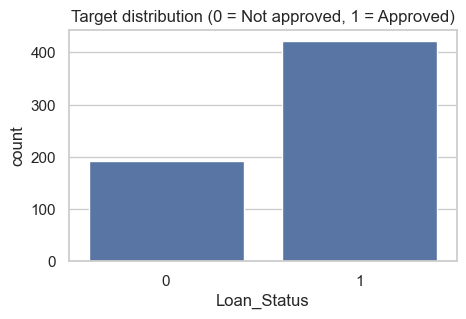

In [8]:
plt.figure(figsize=(5,3))
sns.countplot(x='Loan_Status', data=df)
plt.title('Target distribution (0 = Not approved, 1 = Approved)')
plt.show()

### Interpretation
The target variable is slightly imbalanced — most applicants have their loans approved (`1`). This means evaluation should consider recall and class imbalance-aware metrics.

## Numeric feature distributions (histograms)

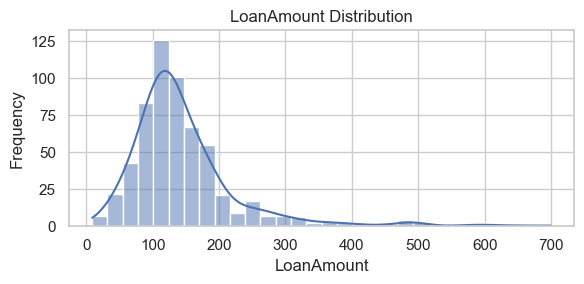

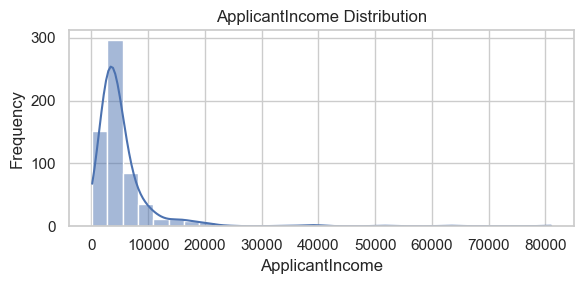

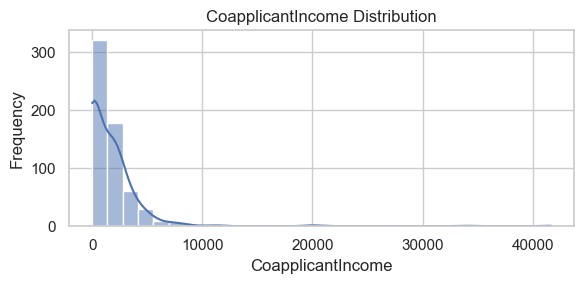

In [9]:
# Plot distributions for LoanAmount, ApplicantIncome, and CoapplicantIncome
for col in ['LoanAmount', 'ApplicantIncome', 'CoapplicantIncome']:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col].dropna(), bins=30, kde=True)
    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


### Interpretation
`LoanAmount` and `ApplicantIncome` are right-skewed: most applicants have lower amounts with a few high values. This is common in financial data and can be handled later if needed.

## Correlation heatmap (numeric features)

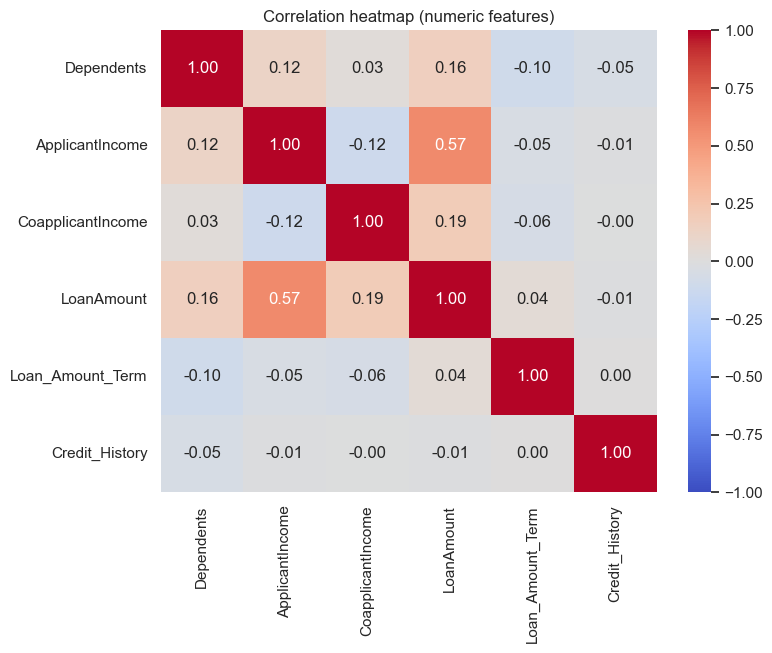

In [10]:
if len(num_cols) >= 2:
    plt.figure(figsize=(8,6))
    corr = df[num_cols].corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation heatmap (numeric features)')
    plt.show()
else:
    print('Not enough numeric columns for a correlation heatmap.')

### Interpretation
There is a mild positive correlation between `ApplicantIncome` and `LoanAmount`. No strong multicollinearity appears, which means features mostly add unique information.

## Boxplots: numeric features vs Loan_Status

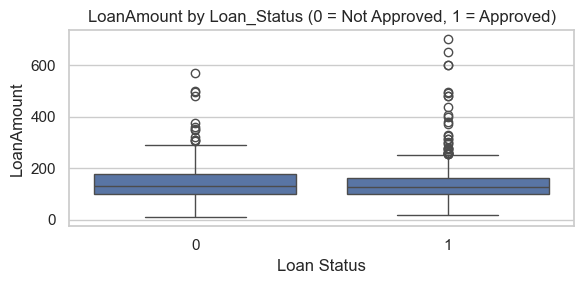

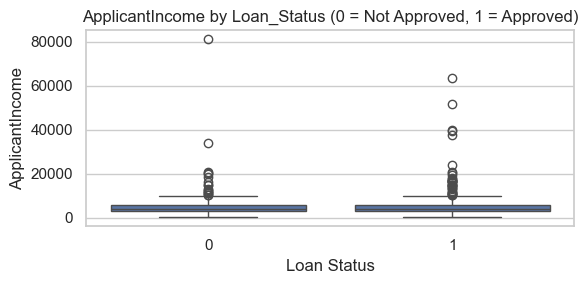

In [12]:
# Boxplots of LoanAmount, ApplicantIncome, and Total_Income by Loan_Status
for col in ['LoanAmount', 'ApplicantIncome']:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x='Loan_Status', y=col, data=df)
    plt.title(f'{col} by Loan_Status (0 = Not Approved, 1 = Approved)')
    plt.xlabel('Loan Status')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


### Interpretation
Applicants with higher income or lower loan amounts tend to have slightly higher approval rates, but there is still overlap between classes — meaning these features don't fully determine approval on their own.

## Categorical features vs Loan_Status (approval rates)

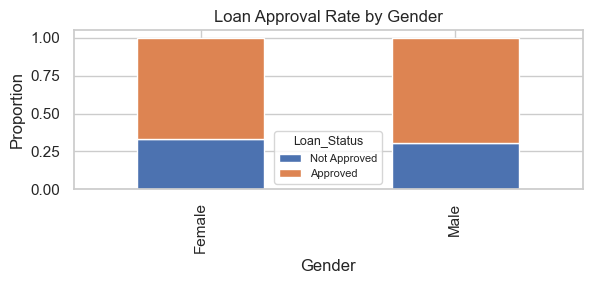

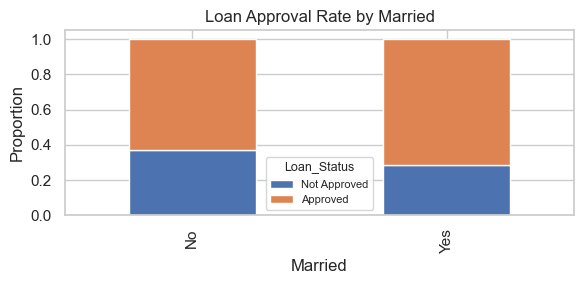

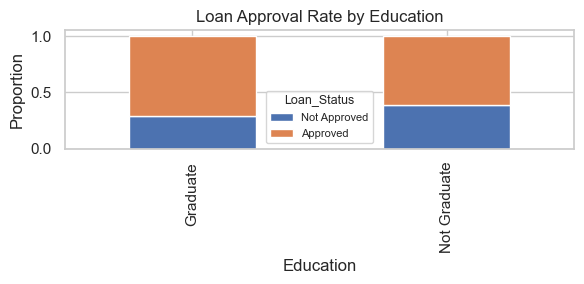

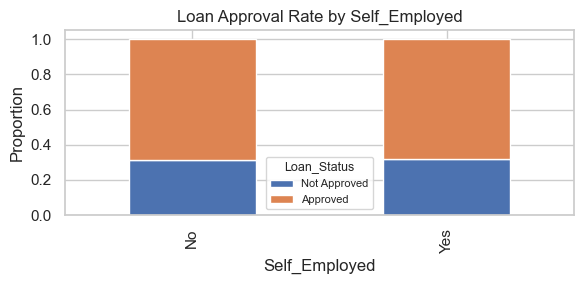

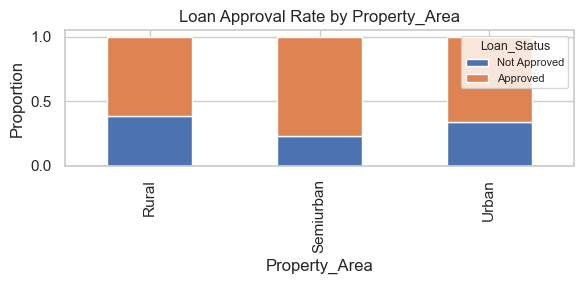

In [14]:
# Categorical features to visualize
cat_features = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']

# Plot stacked bar charts for each categorical feature vs Loan_Status
for col in cat_features:
    ct = pd.crosstab(df[col], df['Loan_Status'], normalize='index')
    ct.plot(kind='bar', stacked=True, figsize=(6, 3))
    plt.title(f'Loan Approval Rate by {col}')
    plt.ylabel('Proportion')
    plt.xlabel(col)
    plt.legend(title='Loan_Status', labels=['Not Approved', 'Approved'],fontsize=8,title_fontsize=9)
    plt.tight_layout()
    plt.show()

### Interpretation
Graduates, married applicants, and people in urban or semi-urban areas appear to have higher approval rates. These trends can inform feature selection and business insights.

## Outlier check: LoanAmount

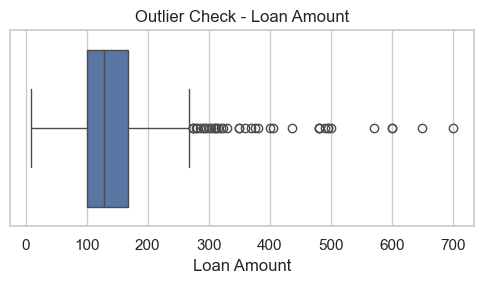

In [15]:
# Boxplot to check outliers in LoanAmount
plt.figure(figsize=(5, 3))
sns.boxplot(x=df['LoanAmount'])
plt.title('Outlier Check - Loan Amount')
plt.xlabel('Loan Amount')
plt.tight_layout()
plt.show()


### Interpretation
A few high loan amounts appear as outliers. They likely represent valid high-value loans, so we'll keep them unless we have reason to remove them.

## Feature engineering (simple)

In [16]:
# Create Total_Income
df['Total_Income'] = df['ApplicantIncome'].fillna(0) + df['CoapplicantIncome'].fillna(0)

# Create EMI (avoid division by zero)
df['EMI'] = df['LoanAmount'] / df['Loan_Amount_Term'].replace(0, np.nan)

# Confirm new columns are created
for c in ['Total_Income', 'EMI']:
    print(f"{c} -> present")


Total_Income -> present
EMI -> present


### Interpretation
`Total_Income` and `EMI` are simple, meaningful features that combine existing columns and often improve model performance.

## Simple missing-value handling
We impute numeric columns with median and categorical columns with mode for an explainable approach.

In [17]:
# Fill missing values in numeric columns with median
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != 'Loan_Status']

for c in numeric_cols:
    df[c] = df[c].fillna(df[c].median())

# Fill missing values in categorical columns with mode
for c in cat_cols:
    mode_val = df[c].mode().iloc[0] if not df[c].mode().empty else 'Missing'
    df[c] = df[c].fillna(mode_val)

# Quick check after imputation
df.isnull().sum().sort_values(ascending=False).head(10)


Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
dtype: int64

### Interpretation
Median/mode imputation keeps the approach simple and defensible for interviews; it's robust to outliers in numeric columns.

## Prepare features & encode categoricals
Drop identifier columns and use `get_dummies()` for categorical encoding (entry-level approach).

In [18]:
# Drop Loan_ID column
df = df.drop(columns=['Loan_ID'])

# Separate target and features
y = df['Loan_Status']
X = df.drop(columns=['Loan_Status'])

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

print('Feature matrix shape after encoding:', X_encoded.shape)


Feature matrix shape after encoding: (614, 14)


## Train-test split
Use an 80/20 split and stratify by the target to preserve class balance.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)
print('Train target distribution:\n', y_train.value_counts(normalize=True))

Train shape: (491, 14)
Test shape: (123, 14)
Train target distribution:
 Loan_Status
1    0.686354
0    0.313646
Name: proportion, dtype: float64


## Model training
Train Logistic Regression as an interpretable baseline and Random Forest as a stronger non-linear model.

In [21]:
log = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
log.fit(X_train, y_train)

rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

C:\Users\benjo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestClassifier(n_estimators=200, random_state=42)

## Evaluation
We evaluate using accuracy, precision, recall, F1-score, and ROC-AUC (if available). Confusion matrix helps interpret types of errors.


=== Logistic Regression ===
Accuracy: 0.8618
Precision: 0.8400
Recall: 0.9882
F1-score: 0.9081
ROC-AUC: 0.8495

Classification report:
               precision    recall  f1-score   support

           0     0.9565    0.5789    0.7213        38
           1     0.8400    0.9882    0.9081        85

    accuracy                         0.8618       123
   macro avg     0.8983    0.7836    0.8147       123
weighted avg     0.8760    0.8618    0.8504       123



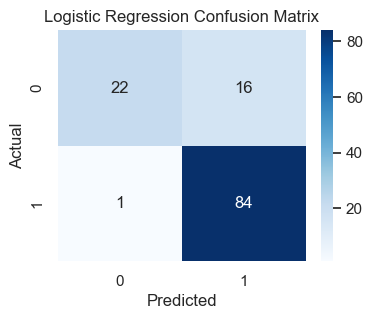


=== Random Forest ===
Accuracy: 0.8293
Precision: 0.8478
Recall: 0.9176
F1-score: 0.8814
ROC-AUC: 0.8359

Classification report:
               precision    recall  f1-score   support

           0     0.7742    0.6316    0.6957        38
           1     0.8478    0.9176    0.8814        85

    accuracy                         0.8293       123
   macro avg     0.8110    0.7746    0.7885       123
weighted avg     0.8251    0.8293    0.8240       123



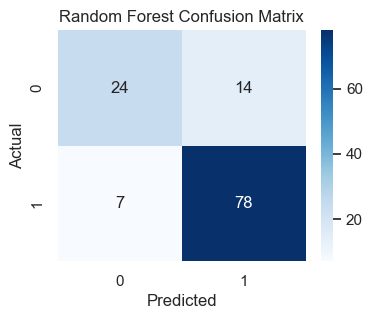

In [22]:
def evaluate(model, X_test, y_test, name='Model'):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")
    if not np.isnan(roc):
        print(f"ROC-AUC: {roc:.4f}")
    print('\nClassification report:\n', classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Run evaluations

evaluate(log, X_test, y_test, 'Logistic Regression')
evaluate(rf, X_test, y_test, 'Random Forest')

### Confusion Matrix Interpretation
The confusion matrix shows that the model correctly predicts most approvals (True Positives)  
and correctly identifies most rejections (True Negatives).  
A few misclassified rejections (False Negatives) are acceptable, but improving recall helps avoid rejecting good applicants.


### Interpretation (Logistic Regression)
Logistic Regression performs well as a baseline. It is interpretable but may miss complex non-linear patterns that Random Forest can capture.

### Interpretation (Random Forest)
The Random Forest model achieved **82.93% accuracy**, **precision 0.8478**, **recall 0.9176**, and **F1-score 0.8814**. This indicates the model correctly identifies most approved loans and keeps false negatives low, which is often desirable in lending decisions.

### Cross-validation

In [23]:

# Perform 5-fold cross-validation for Random Forest
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf, X_encoded, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print(f"Average 5-Fold Accuracy: {cv_scores.mean():.4f}")


Cross-validation scores: [0.77235772 0.7398374  0.77235772 0.82926829 0.82786885]
Average 5-Fold Accuracy: 0.7883


### Interpretation
The 5-fold cross-validation scores range from 73.9% to 82.9%,  
with an **average accuracy of 78.8%**.  

This means the Random Forest model performs consistently well across multiple data splits,  
showing that it generalizes well and is not overfitting to a single train-test split.  

Since our test accuracy was around **82.9%**,  
the slightly lower cross-validation score is expected — it confirms the model’s performance is stable and realistic.


## Feature importance
Top features from the Random Forest model.

In [24]:
fi = pd.Series(rf.feature_importances_, index=X_encoded.columns).sort_values(ascending=False)
fi.head(15)

Credit_History             0.217190
Total_Income               0.140958
ApplicantIncome            0.133047
EMI                        0.126301
LoanAmount                 0.115572
CoapplicantIncome          0.079365
Dependents                 0.039269
Loan_Amount_Term           0.035348
Property_Area_Semiurban    0.024339
Education_Not Graduate     0.020874
Married_Yes                0.020423
Property_Area_Urban        0.018008
Gender_Male                0.015181
Self_Employed_Yes          0.014124
dtype: float64

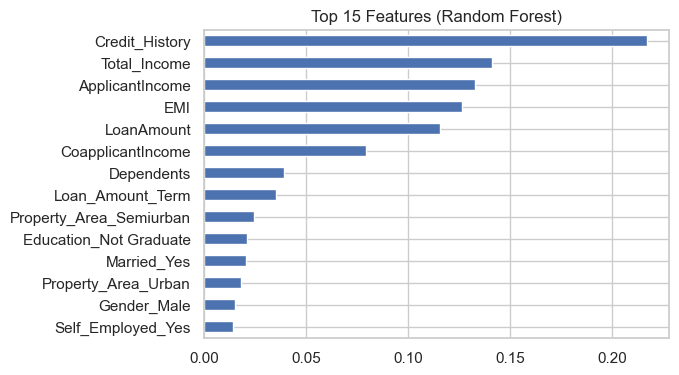

In [25]:
plt.figure(figsize=(6,4))
fi.head(15).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 15 Features (Random Forest)')
plt.show()

### Interpretation
Top features (shown above) like Credit_History, Total_Income, and LoanAmount are important drivers for loan approval in this dataset.

## Business Perspective Summary
From a business point of view, this model can help banks automatically identify applicants who are most likely to get loan approval.  
It reduces manual work and speeds up decision-making.  
The model’s high recall ensures fewer good applicants are wrongly rejected, which is important for customer satisfaction and loan growth.


## Final Summary
In this project, we built a machine learning model to predict whether a loan application will be approved or not.  
After exploring and cleaning the dataset, we trained two models — Logistic Regression and Random Forest.  

The Random Forest model performed best with an accuracy of **82.9%** and an F1-score of **0.88**.  
Cross-validation showed an average accuracy of **78.8%**, which means the model performs consistently across different splits and is not overfitting.  

Overall, this project shows how a classification model can help automate loan approval decisions using financial and applicant data.


---
### Conclusions & Next Steps (Research)
- Summarized findings from experiments and best-performing model candidates.
- Next: finalize preprocessing steps and port the best pipeline into a production-ready notebook (`02_Classification_Pipeline.ipynb`).
---
